In [1]:
import torch

In [2]:
import os 
print(os.getcwd())

C:\Users\yxgong


### dataset

In [3]:
#  datasets dir
voc_root="./Dataset/VOCdevkit/VOC2012/"
print(voc_root)

./Dataset/VOCdevkit/VOC2012/


In [4]:
def read_images(root=voc_root,train=True):
    txt_filename=root+"/ImageSets/Segmentation/"+('train.txt'if train else 'val.txt')
    with open(txt_filename,'r') as f:
        images=f.read().split()
    data=[os.path.join(root,'JPEGImages',i+'.jpg')for i in images]
    label=[os.path.join(root,'SegmentationClass',i+'.png')for i in images]
    return data,label

In [5]:
import os
data,label=read_images()
# print(data,label)

In [6]:
import random
from torchvision.transforms import transforms as tfs
def rand_crop(data,label,height,width):
    h,w,_=data.shape
    top=random.randint(0,h-height)
    left=random.randint(0,w-width)
    data=data[top:top+height,left:left+width]
    label=label[top:top+height,left:left+width]
    return data,label

In [7]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [8]:
import numpy as np
cm2lbl=np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]]=i

def image2label(im):
    data=np.array(im,dtype='int32')
    idx=(data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return np.array(cm2lbl[idx],dtype='int64')

In [9]:
from PIL import Image
label_im = Image.open('./Dataset/VOCdevkit/VOC2012/SegmentationClass/2007_000033.png').convert('RGB')
label_im.show()
label = image2label(label_im)
label[150:160, 240:250]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

In [10]:
def img_transforms(im,label,crop_size):
    im,label=rand_crop(im,label,*crop_size)
    im_tfs=tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    im=im_tfs(im)
    label=image2label(label)
    label=torch.from_numpy(label)
    return im,label

In [11]:
from torch.utils.data import Dataset
import cv2
class VOCSegDataset(Dataset):
    def __init__(self,train,crop_size,transforms):
        self.crop_size=crop_size
        self.transforms=transforms
        data_list,label_list=read_images(train=train)
        self.data_list=self._filter(data_list)
        self.label_list=self._filter(label_list)
        print('Read'+ ' '+ str(len(self.data_list))+' '+'images')
    def _filter(self,images):
        return [im for im in images if(Image.open(im).size[1] >= self.crop_size[0] and
                                      Image.open(im).size[0] >= self.crop_size[1])]
    def __getitem__(self,idx):
        img=self.data_list[idx]
        label=self.label_list[idx]
        img=cv2.imread(img)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label=cv2.imread(label)
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        img,label=self.transforms(img,label,self.crop_size)
        return img,label
    
    def __len__(self):
        return len(self.data_list)

In [12]:
input_shape=(320,480)
voc_train=VOCSegDataset(True,input_shape,img_transforms)
voc_test=VOCSegDataset(False,input_shape,img_transforms)

Read 1114 images
Read 1078 images


In [13]:
from torch.utils.data import DataLoader
train_data=DataLoader(voc_train,batch_size=16,shuffle=True)
valid_data=DataLoader(voc_test,batch_size=16)

In [14]:
import torch
import  matplotlib.pyplot as plt
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    og=np.ogrid[:kernel_size,:kernel_size]
    filt=(1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
    weight=np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
    weight[range(in_channels),range(out_channels),:,:]=filt
    return torch.from_numpy(weight)

x=Image.open('./Dataset/VOCdevkit/VOC2012/JPEGImages/2007_005210.jpg')
x=np.array(x)
plt.imshow(x)
plt.show()

<Figure size 640x480 with 1 Axes>

(562, 1000, 3)


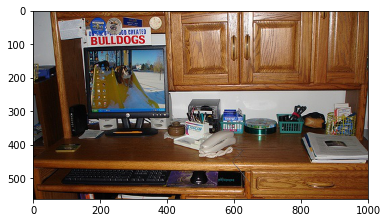

In [15]:
import  torch.nn as nn
from torch.autograd import Variable
x=torch.from_numpy(x.astype('float32')).permute(2,0,1).unsqueeze(0)
conv_trans=nn.ConvTranspose2d(3,3,4,2,1)
conv_trans.weight.data=bilinear_kernel(3,3,4)

y=conv_trans(Variable(x)).data.squeeze().permute(1,2,0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

### model

In [16]:
from torchvision import models
pretrained_net=models.resnet34(pretrained=True)
num_classes=len(classes)

In [17]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
#         print('s1.shape',s1.shape)  #s1.shape torch.Size([6, 128, 40, 60])
        
        x = self.stage2(x)
        s2 = x # 1/16
#         print('s2.shape',s2.shape)  #s2.shape torch.Size([6, 256, 20, 30])
        
        x = self.stage3(x)
        s3 = x # 1/32
#         print('s3.shape',s3.shape) #s3.shape torch.Size([6, 512, 10, 15])
        
        s3 = self.scores1(s3)
#         print('s3.shape',s3.shape)  #s3.shape torch.Size([6, 21, 10, 15])
        s3 = self.upsample_2x(s3)
#         print('s3.shape',s3.shape) #s3.shape torch.Size([6, 21, 20, 30])

        s2 = self.scores2(s2)
#         print('s2.shape',s2.shape)  #s2.shape torch.Size([6, 21, 20, 30]) 
        
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
#         print('s1.shape',s1.shape)  s1.shape torch.Size([6, 21, 40, 60])
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s
        

In [18]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

### optim

In [19]:
criterion = nn.NLLLoss2d()

net=fcn(num_classes)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


### Train

In [20]:
import time
import torch.nn.functional as F
min_acc = 0
for e in range(200):
    
    train_loss = 0
    train_acc = 0
    train_acc_cls = 0
    train_mean_iu = 0
    train_fwavacc = 0
    
    prev_time = time.time()
    net = net.train()
    net=net.cuda()
    for data in train_data:
        im = Variable(data[0].cuda())
        label = Variable(data[1].cuda())
#         print(label.shape)
        # forward
        out = net(im)
#         print(out.shape)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            train_acc += acc
            train_acc_cls += acc_cls
            train_mean_iu += mean_iu
            train_fwavacc += fwavacc
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_acc_cls = 0
    eval_mean_iu = 0
    eval_fwavacc = 0
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        label = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        eval_loss += loss.data
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            eval_acc += acc
            eval_acc_cls += acc_cls
            eval_mean_iu += mean_iu
            eval_fwavacc += fwavacc
        
    cur_time = time.time()

    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(voc_train), train_mean_iu / len(voc_train),
        eval_loss / len(valid_data), eval_acc / len(voc_test), eval_mean_iu / len(voc_test)))
    
    if (eval_acc / len(voc_test)) > min_acc:
            min_acc = eval_acc / len(voc_test)
            torch.save(net.state_dict(),'new_fcn_resnet34_%d.pth'%e)
   
    print(epoch_str)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 0, Train Loss: 1.12451, Train Acc: 0.74421, Train Mean IU: 0.27652, Valid Loss: 0.73709, Valid Acc: 0.80294, Valid Mean IU: 0.36303 
Epoch: 1, Train Loss: 0.66338, Train Acc: 0.82176, Train Mean IU: 0.38995, Valid Loss: 0.57537, Valid Acc: 0.83870, Valid Mean IU: 0.43798 
Epoch: 2, Train Loss: 0.53963, Train Acc: 0.84521, Train Mean IU: 0.44504, Valid Loss: 0.52551, Valid Acc: 0.84952, Valid Mean IU: 0.45236 
Epoch: 3, Train Loss: 0.46737, Train Acc: 0.86012, Train Mean IU: 0.46819, Valid Loss: 0.47477, Valid Acc: 0.85727, Valid Mean IU: 0.48147 
Epoch: 4, Train Loss: 0.42275, Train Acc: 0.87036, Train Mean IU: 0.49717, Valid Loss: 0.45443, Valid Acc: 0.86087, Valid Mean IU: 0.49091 
Epoch: 5, Train Loss: 0.38941, Train Acc: 0.87795, Train Mean IU: 0.51026, Valid Loss: 0.44510, Valid Acc: 0.86275, Valid Mean IU: 0.50581 
Epoch: 6, Train Loss: 0.36246, Train Acc: 0.88501, Train Mean IU: 0.52931, Valid Loss: 0.43583, Valid Acc: 0.86477, Valid Mean IU: 0.49743 
Epoch: 7, Train Loss

Epoch: 58, Train Loss: 0.12746, Train Acc: 0.95467, Train Mean IU: 0.73742, Valid Loss: 0.39461, Valid Acc: 0.88609, Valid Mean IU: 0.53186 
Epoch: 59, Train Loss: 0.12777, Train Acc: 0.95461, Train Mean IU: 0.73313, Valid Loss: 0.40024, Valid Acc: 0.88571, Valid Mean IU: 0.53035 
Epoch: 60, Train Loss: 0.12792, Train Acc: 0.95458, Train Mean IU: 0.73350, Valid Loss: 0.40668, Valid Acc: 0.88582, Valid Mean IU: 0.53441 
Epoch: 61, Train Loss: 0.12573, Train Acc: 0.95520, Train Mean IU: 0.73793, Valid Loss: 0.40556, Valid Acc: 0.88710, Valid Mean IU: 0.53950 
Epoch: 62, Train Loss: 0.12398, Train Acc: 0.95565, Train Mean IU: 0.74152, Valid Loss: 0.40770, Valid Acc: 0.88651, Valid Mean IU: 0.53951 
Epoch: 63, Train Loss: 0.12607, Train Acc: 0.95503, Train Mean IU: 0.74054, Valid Loss: 0.39767, Valid Acc: 0.88769, Valid Mean IU: 0.53476 
Epoch: 64, Train Loss: 0.12483, Train Acc: 0.95534, Train Mean IU: 0.73601, Valid Loss: 0.39686, Valid Acc: 0.88818, Valid Mean IU: 0.52931 
Epoch: 65, Tr

Epoch: 115, Train Loss: 0.09860, Train Acc: 0.96352, Train Mean IU: 0.78503, Valid Loss: 0.41424, Valid Acc: 0.88954, Valid Mean IU: 0.53621 
Epoch: 116, Train Loss: 0.09958, Train Acc: 0.96341, Train Mean IU: 0.78411, Valid Loss: 0.42095, Valid Acc: 0.88962, Valid Mean IU: 0.53795 
Epoch: 117, Train Loss: 0.09807, Train Acc: 0.96378, Train Mean IU: 0.78669, Valid Loss: 0.42441, Valid Acc: 0.88980, Valid Mean IU: 0.54187 
Epoch: 118, Train Loss: 0.09794, Train Acc: 0.96375, Train Mean IU: 0.78302, Valid Loss: 0.41758, Valid Acc: 0.89033, Valid Mean IU: 0.54112 
Epoch: 119, Train Loss: 0.09945, Train Acc: 0.96319, Train Mean IU: 0.78560, Valid Loss: 0.41368, Valid Acc: 0.89021, Valid Mean IU: 0.53565 
Epoch: 120, Train Loss: 0.09824, Train Acc: 0.96378, Train Mean IU: 0.78535, Valid Loss: 0.41571, Valid Acc: 0.88976, Valid Mean IU: 0.52993 
Epoch: 121, Train Loss: 0.09752, Train Acc: 0.96380, Train Mean IU: 0.78912, Valid Loss: 0.41600, Valid Acc: 0.89083, Valid Mean IU: 0.54017 
Epoch:

Epoch: 172, Train Loss: 0.08727, Train Acc: 0.96726, Train Mean IU: 0.81244, Valid Loss: 0.43341, Valid Acc: 0.89145, Valid Mean IU: 0.53822 
Epoch: 173, Train Loss: 0.08655, Train Acc: 0.96743, Train Mean IU: 0.80758, Valid Loss: 0.43290, Valid Acc: 0.89248, Valid Mean IU: 0.54502 
Epoch: 174, Train Loss: 0.08674, Train Acc: 0.96749, Train Mean IU: 0.81336, Valid Loss: 0.42386, Valid Acc: 0.89177, Valid Mean IU: 0.54011 
Epoch: 175, Train Loss: 0.08578, Train Acc: 0.96773, Train Mean IU: 0.80900, Valid Loss: 0.43318, Valid Acc: 0.89148, Valid Mean IU: 0.53681 
Epoch: 176, Train Loss: 0.08783, Train Acc: 0.96711, Train Mean IU: 0.81111, Valid Loss: 0.42446, Valid Acc: 0.89169, Valid Mean IU: 0.53340 
Epoch: 177, Train Loss: 0.08644, Train Acc: 0.96763, Train Mean IU: 0.81065, Valid Loss: 0.42012, Valid Acc: 0.89218, Valid Mean IU: 0.53530 
Epoch: 178, Train Loss: 0.08685, Train Acc: 0.96728, Train Mean IU: 0.80884, Valid Loss: 0.43485, Valid Acc: 0.89242, Valid Mean IU: 0.54373 
Epoch:

### predict

In [21]:
net=fcn(num_classes)
net.load_state_dict(torch.load('./new_fcn_resnet34_194.pth'))
net=net.cuda()

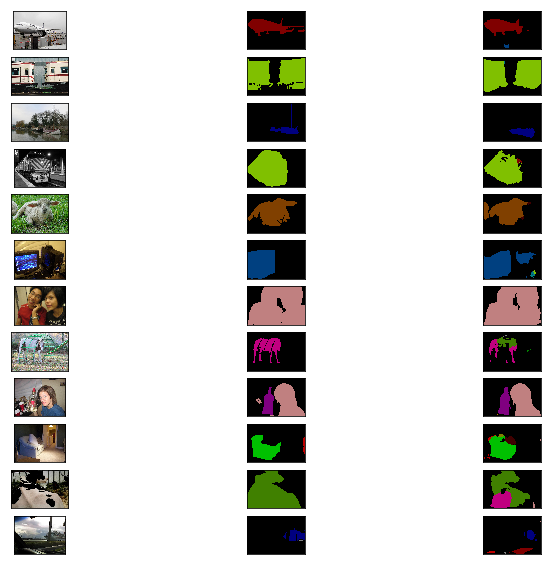

In [22]:
# 定义预测函数
cm = np.array(colormap).astype('uint8')

def predict(im, label): # 预测结果
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]


_, figs = plt.subplots(12, 3, figsize=(12, 10))
for i in range(12):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)

### Dataset_duck

In [23]:
#  datasets dir
duck_root="./Dataset/DukeMTMC-reID/"
if os.path.exists(duck_root):
    print(duck_root)

./Dataset/DukeMTMC-reID/


In [24]:
def read_images_duck(root=duck_root):
    txt_filename=root+'query/'
    images = os.listdir(txt_filename)
    data=[os.path.join(txt_filename,i)for i in images]
    return data

In [25]:
import os
data=read_images_duck()
print(data[0])
if os.path.exists(data[0]):
    print('true')

./Dataset/DukeMTMC-reID/query/0005_c2_f0046985.jpg
true


In [26]:
'''
RuntimeError: The size of tensor a (7) must match the size of tensor b (8) at non-singleton dimension 3
由于输入图像的尺寸除以2，再除以2的时候会出现奇数，比如34，除以2为17，再除以2则除不了，再进行尺寸翻倍的时候，
会出现尺码size不一致的情况发生，所以我们需要前期在尺度下手，提前进行crop,修改尺寸成为可以除以4的情况。
s1.shape torch.Size([1, 128, 34, 14])
s2.shape torch.Size([1, 256, 17, 7])
s3.shape torch.Size([1, 512, 9, 4])
s3.shape torch.Size([1, 21, 9, 4])
s3.shape torch.Size([1, 21, 18, 8])
s2.shape torch.Size([1, 21, 17, 7])
这里rand_crop_duck进行裁剪图像以适合网络，为什么整除32，因为resnet需要图像整除8，而之后的fcn需要图像能整除4，则为32
'''

'\nRuntimeError: The size of tensor a (7) must match the size of tensor b (8) at non-singleton dimension 3\n由于输入图像的尺寸除以2，再除以2的时候会出现奇数，比如34，除以2为17，再除以2则除不了，再进行尺寸翻倍的时候，\n会出现尺码size不一致的情况发生，所以我们需要前期在尺度下手，提前进行crop,修改尺寸成为可以除以4的情况。\ns1.shape torch.Size([1, 128, 34, 14])\ns2.shape torch.Size([1, 256, 17, 7])\ns3.shape torch.Size([1, 512, 9, 4])\ns3.shape torch.Size([1, 21, 9, 4])\ns3.shape torch.Size([1, 21, 18, 8])\ns2.shape torch.Size([1, 21, 17, 7])\n这里rand_crop_duck进行裁剪图像以适合网络，为什么整除32，因为resnet需要图像整除8，而之后的fcn需要图像能整除4，则为32\n'

In [27]:
import random
from torchvision.transforms import transforms as tfs
def rand_crop_duck(data):
    h,w,_=data.shape
    
    while h>0:
        if h%32 != 0:
            h-=1
        else:break

    while w>0:
        if w%32 != 0: 
            w-=1 
        else:break  
    
    data=data[0:h,0:w]
#     print(data.shape)
    return data

In [28]:
h,w= 120,40
while h>0:
    if h%32 != 0:
        h-=1
    else:
        break

while w>0:
    if w%32 != 0: 
        w-=1 
    else:break
    
print(h)
print(w)

96
32


In [29]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# RGB color for each class
colormap_duck = [[0,0,0],[0,0,0],[0,0,0], [0,0,0], [0,0,0],
            [0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],
            [0,0,0],[0,0,0],[0,0,0],[0,0,0],
            [0,0,0],[192,128,128],[0,0,0],[0,0,0],
            [0,0,0],[0,0,0],[0,0,0]]

len(classes), len(colormap_duck)

(21, 21)

In [30]:
def duck_transforms(im):
    im=rand_crop_duck(im)
    im_tfs=tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    im=im_tfs(im)
    return im

In [31]:
from torch.utils.data import Dataset
import cv2
class duckSegDataset(Dataset):
    def __init__(self,transforms):
        self.transforms=transforms
        self.data_list=read_images_duck()
#         self.data_list=self._filter(data_list)
        print('Read'+str(len(self.data_list))+'images')
    def _filter(self,images):
        return [im for im in images if(Image.open(im).size[0] >= self.crop_size[0] and
                                      Image.open(im).size[1] >= self.crop_size[1])]
    def __getitem__(self,idx):
        img=self.data_list[idx]
        img=cv2.imread(img)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=self.transforms(img)
        return img
    
    def __len__(self):
        return len(self.data_list)

In [32]:
# input_shape=(50,150)
duck_test=duckSegDataset(duck_transforms)

Read2228images


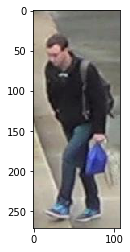

In [33]:
import torch
import  matplotlib.pyplot as plt

x=Image.open(data[0])
x=np.array(x)
plt.imshow(x)
plt.show()

In [34]:
class fcn_dunck(nn.Module):
    def __init__(self, num_classes):
        super(fcn_dunck, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
#         print('x.shape',x.shape)
        x = self.stage1(x)
        s1 = x # 1/8
#         print('s1.shape',s1.shape)  #s1.shape torch.Size([6, 128, 40, 60])
        
        x = self.stage2(x)
        s2 = x # 1/16
#         print('s2.shape',s2.shape)  #s2.shape torch.Size([6, 256, 20, 30])
        
        x = self.stage3(x)
        s3 = x # 1/32
#         print('s3.shape',s3.shape) #s3.shape torch.Size([6, 512, 10, 15])
        
        s3 = self.scores1(s3)
#         print('s3.shape',s3.shape)  #s3.shape torch.Size([6, 21, 10, 15])
        s3 = self.upsample_2x(s3)
#         print('s3.shape',s3.shape) #s3.shape torch.Size([6, 21, 20, 30])

        s2 = self.scores2(s2)
#         print('s2.shape',s2.shape)  #s2.shape torch.Size([6, 21, 20, 30]) 
        
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
#         print('s1.shape',s1.shape)  s1.shape torch.Size([6, 21, 40, 60])
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s
        

In [35]:
from torchvision import models
pretrained_net=models.resnet34(pretrained=True)
num_classes=len(classes)
net_duck=fcn_dunck(num_classes)
net_duck.load_state_dict(torch.load('./new_fcn_resnet34_194.pth'))
net_duck=net_duck.cuda()

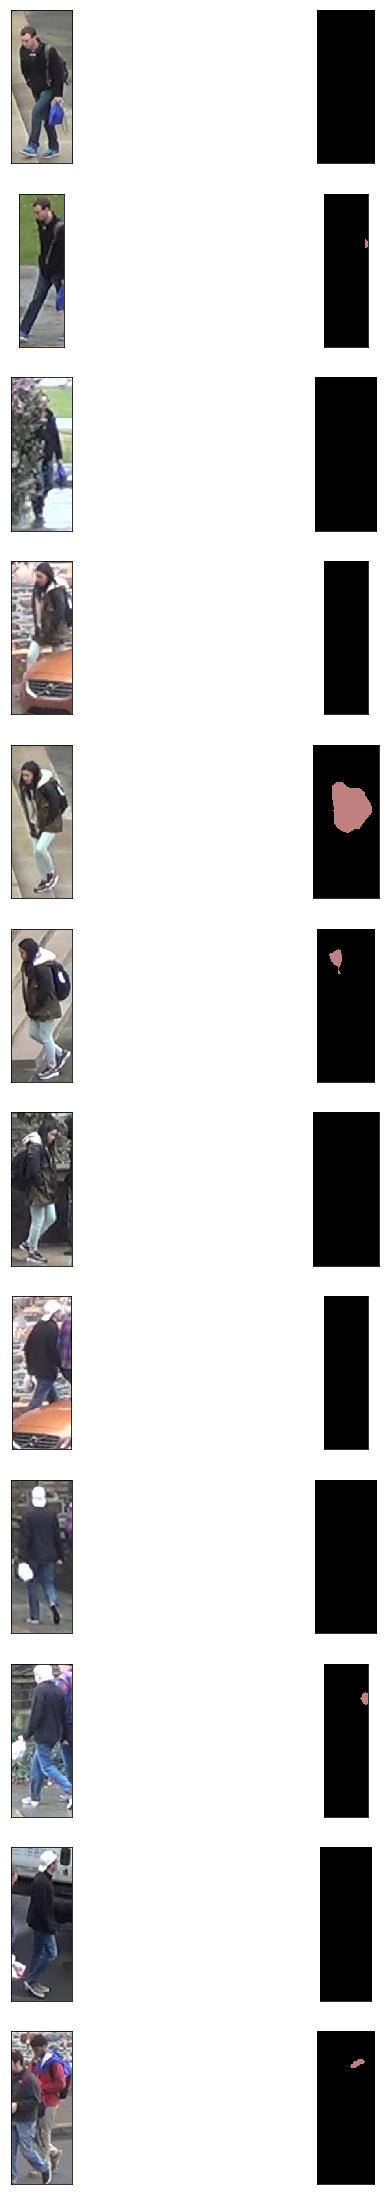

In [36]:
# 定义预测函数
cm = np.array(colormap_duck).astype('uint8')

def predict(net,im): # 预测结果
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred


_, figs = plt.subplots(12, 2, figsize=(10, 40))
for i in range(12):
    test_data = duck_test[i]
    pred = predict(net_duck,test_data)
    figs[i, 0].imshow(Image.open(duck_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(pred)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
